# 使用 Python 对图像中的洪水进行分类
# Classify Imagery to detect flooding with Python
对于洪水事件，有时候需要快速分析卫星影像并确定最近被洪水淹没的区域。
在本课程中，您将学习如何开发自动化工具来识别卫星影像中的洪水区域。您将首先在 ArcGIS Pro 中使用在notebook 一步步实现洪水检测的目的。然后，会将代码转换为脚本工具，供没有编程背景的分析师使用。
本课程需要了解Python和Arcpy，并且对遥感有一定了解，如果不熟悉Python，请查看：
- For a quick introduction to Python, see the first three lessons in the [Learn Python with ArcGIS Notebooks](https://learn.arcgis.com/en/paths/learn-python-with-arcgis-notebooks/) path.  
有关 Python 的快速介绍，请参阅使用 ArcGIS Notebooks 学习 Python 路径中的前三课。
- 
- For more information about remote sensing in ArcGIS, see the [Introduction to Imagery and Remote Sensing](https://introduction-to-remote-sensing-learngis.hub.arcgis.com/) curriculum.
有关 ArcGIS 中遥感的详细信息，请参阅影像和遥感简介课程。

### 下载相应影像
首先，您将下载用于分析的影像。如何下载影像以及相关基础知识可以查看[4.2.8-栅格数据.md](4.2.8-%D5%A4%B8%F1%CA%FD%BE%DD.md)。
本课程使用的影像是来自欧盟哥白尼地球观测计划中哨兵卫星计划的处理后的影像，分为洪水前和洪水后。

你可以点击 [Sentinel_2_Clipped.zip](https://arcgis.com/sharing/rest/content/items/9cfeb37e929a4b0484be5235da16e0bf/data)下载。

下载后，将其解压缩到您的计算机上。解压缩后，您将看到三个文件夹，分别包含Before, After, and Output：洪水前和洪水后的影像以及输出文件夹。

### 导入所需的 Python 模块和包

In [3]:
import os
from glob import glob # 支持简单的路径名匹配和列表生成。
import arcpy
from arcpy.sa import * # 空间分析模块 扩展模块

修改下列文件路径

In [4]:
# 设置一个工程项目文件夹所在的路径
# home_dir = os.path.join(os.getcwd(), "resource", "Classify_Imagery_with_Python") # 外部IDE 使用此行代码

# 软件内部运行：
# os.getcwd()会返回arcgis工程文件所在文件夹，所以不需要这么麻烦，
# 但是为了代码可复用，在内部运行notebook可以在上述代码前修改并加上
os.chdir(r"C:\Users\hncdj\Documents\Python_\Python辅助城市研究\Urban-Spatial-Data-Analysis-For-Beginners\4-空间数据分析\4.2-arcpy") # 用此函数定义当前python脚本工作空间 


home_dir = os.path.join(os.getcwd(), "resource", "Classify_Imagery_with_Python")

# 洪水前影像所在的文件夹
before_img_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\Before")

# 洪水后影像所在的文件夹
after_img_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\After")

# 最后成功输出的文件夹
final_output_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\Output")

# gdb
gdb = os.path.join(home_dir, "Classify_Imagery_with_Python.gdb")

# 因为我是外部notebook编辑，所以需要设置工作空间
arcpy.env.workspace = gdb

arcpy.env.overwriteOutput = True # 覆盖输出

### 

### 定义函数，用于返回相应的合成波段
为了方便后续的调用，我们定义一个函数，用于返回相应的合成波段。
> Sentinel-2 影像通常与存储在单独的 JPEG 2000 （.jp2） 文件中的每个波段一起提供。每个波段文件都以波段编号作为文件名的一部分结尾。例如，红色波段、波段 4、文件名以“B04.jp2”结尾。考虑到这种格式，您将创建一个 Python 函数，该函数将包含波段影像的文件夹作为输入参数，并返回一个变量，该变量引用计算机上每个波段的绝对路径。

In [3]:
def create_sen2_band_variables(in_folder):
    """识别指定文件夹中相应哨兵2卫星光谱波段的文件，并将这些文件的路径存储在变量中。
    
    参数:
    in_folder: 指定文件夹
    
    返回值:
    Blue: 蓝光波段
    Green: 绿光波段
    Red: 红光波段
    Red_Edge_1: 红边波段1
    NIR: 近红外波段
    SWIR2: 短波红外波段
    """
    
    # 使用 arcpy.AddMessage 函数用于在程序中输出信息，方法同print
    arcpy.AddMessage("Creating variables for image bands...")

    # 使用 glob 模块获取输入文件夹中所有.jp2图像文件的列表
    band_list = glob(in_folder + "/*.jp2")

    # 使用列表推导查找与各种 Sentinel-2 波段对应的文件，并将其路径存储在具有各自名称（如 Blue 、、 Green Red 或 NIR ）的变量中。
    Blue = [x for x in band_list if x.endswith("B02.jp2")][0]
    Green = [x for x in band_list if x.endswith("B03.jp2")][0]
    Red = [x for x in band_list if x.endswith("B04.jp2")][0]
    Red_Edge_1 = [x for x in band_list if x.endswith("B05.jp2")][0]
    NIR = [x for x in band_list if x.endswith("B08.jp2")][0]
    SWIR2 = [x for x in band_list if x.endswith("B12.jp2")][0]

    # 返回包含图像文件路径的波段变量。
    return Blue, Green, Red, Red_Edge_1, NIR, SWIR2

In [4]:
# 提取洪水后影像的相应的波段变量
after_Blue, after_Green, after_Red, after_Red_Edge_1, after_NIR, after_SWIR2 = create_sen2_band_variables(after_img_folder)

print(after_Red)
print(after_NIR) 

C:\Users\hncdj\Documents\Python_\Python辅助城市研究\Urban-Spatial-Data-Analysis-For-Beginners\4-空间数据分析\4.2-arcpy\resource\Classify_Imagery_with_Python\Sentinel_2_Clipped\After\Clipped_T42TVK_20200504T061629_B04.jp2
C:\Users\hncdj\Documents\Python_\Python辅助城市研究\Urban-Spatial-Data-Analysis-For-Beginners\4-空间数据分析\4.2-arcpy\resource\Classify_Imagery_with_Python\Sentinel_2_Clipped\After\Clipped_T42TVK_20200504T061629_B08.jp2


### 选择波段索引的合成方式
合成波段索引可以用波段合成、栅格计算、栅格代数、栅格函数等方式实现。
例如我们可以使用空间分析中的栅格函数`compband_raster = arcpy.sa.CompositeBand([raster,...])`来查看洪水合成彩色红外图像：

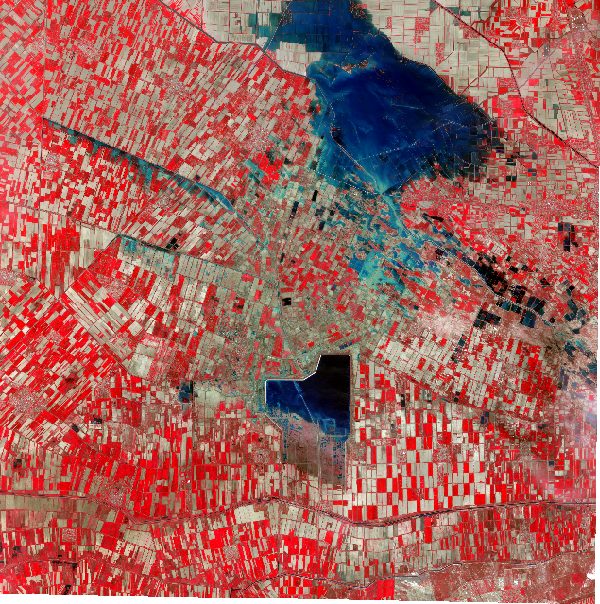

In [5]:
# 运行下面的合成洪水后的假彩色红外图像 
after_composite_img = CompositeBand([after_NIR, after_Red, after_Green])
after_composite_img

假彩色红外图像中植被区域呈现红色，水呈现充满活力的蓝色。

### 选择合适波段、波段索引来提取水元素： SWI和NDWI
要识别影像中的水，您将使用波段索引。光谱指数应用数学计算来计算影像中每个像素的不同波段之间的比率，目的是突出显示特定现象。我在[4.2.8-栅格数据.md](4.2.8-%D5%A4%B8%F1%CA%FD%BE%DD.md)已经介绍过。
为了保证结果的准确性，我们将使用两个指数：Sentinel-2 水指数（ SWI ）和归一化差值水指数 （NDWI）。
SWI 通过计算短波红外（SWIR）和近红外（NIR）波段之间的比率来突出显示水。SWIR波段可以穿透云层，因此SWI可以在云层下检测水。

- SWI 依赖于 Red Edge 1 和 SWIR2 频段。此指数的公式为： SWI = (Red_Edge1 - SWIR2) / (Red_Edge1 + SWIR2)对应波段是（B05-B12）/（B05+B12）

- NDWI使用绿色和近红外（NIR）波段。此指数的公式为： NDWI = (Green - NIR) / (Green + NIR)，对应波段是（B03-B08）/（B03+B08）


此处不能使用合成彩色红外相同的方法合成，针对NDWI有相应的波段索引函数`arcpy.sa.NDWI (raster, {nir_band_id}, {green_band_id})`,但是SWI没有对于的波段，为了代码统一，我们都使用栅格计算工具`arcpy.sa.RasterCalculator (rasters, input_names, expression, {extent_type}, {cellsize_type})`。

In [6]:
# 1.计算SWI
after_swi_calc = RasterCalculator([after_Red_Edge_1, after_SWIR2], 
                 ["x", "y"],
                 "(x - y) / (x + y)", "IntersectionOf")
arcpy.AddMessage("SWI Successfully Generated")
# 可选  保存到数据库 无需后缀
# ！！！ 养成好习惯 一定要在数据库处理
# after_swi_calc.save("after_swi")

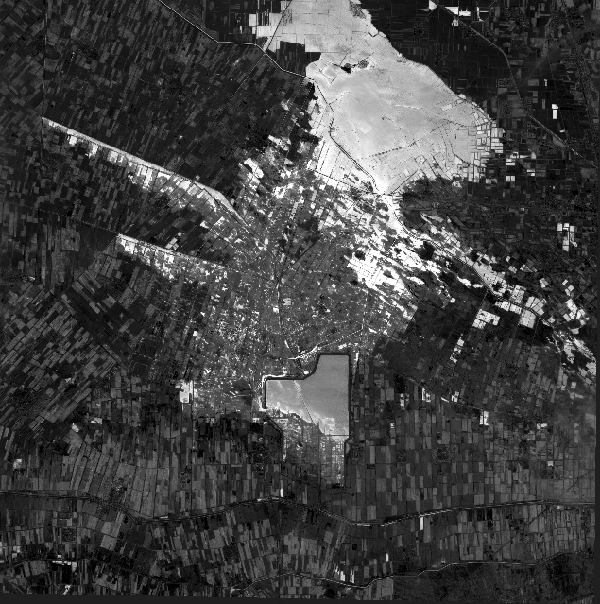

In [7]:
after_swi_calc

In [8]:
# 2.计算NDWI
after_ndwi_calc = RasterCalculator([after_Green, after_NIR], 
                 ["x", "y"],
                 "(x - y) / (x + y)")
arcpy.AddMessage("NDWI Successfully Generated")
# 可选 保存
#after_ndwi_calc.save("after_ndwi.tif")

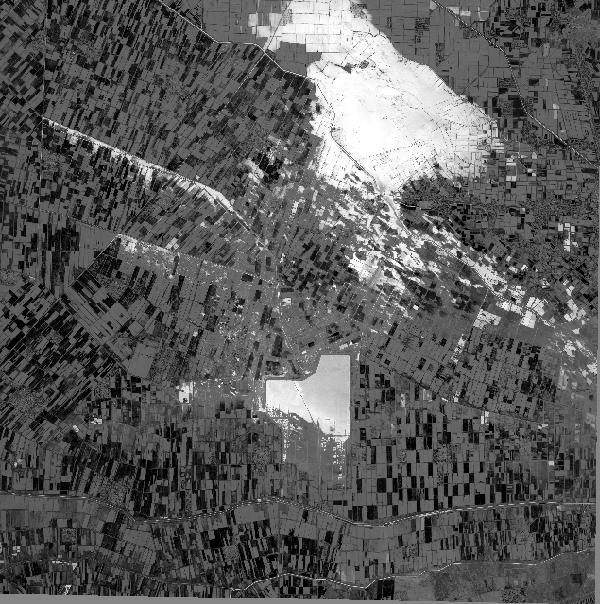

In [9]:
after_ndwi_calc

保存之后添加到地图可以检查影像：
像素值较高的区域对应于水，偏向白色。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242250379.png)

### 创建阈值函数
如何分离非水像素或水像素？
解决此问题的常用方法是使用直方图阈值化（histogram thresholding），这是一种常见的图像处理技术，用于将图像转换为二值图像。该技术基于图像的像素值分布，通过选择适当的阈值来将图像中的像素分为两个类别，通常是前景和背景（ 0 或 1）。
> ![histogram thresholding](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242257428.png)
> 直方图阈值化的过程涉及计算图像的像素值直方图，该直方图显示了不同像素值的频率分布。通过分析直方图的形状和峰值，可以选择一个合适的阈值来将图像分割为两个部分。所有低于阈值的像素被标记为一个类别（通常是背景），而高于阈值的像素被标记为另一个类别（通常是前景）。
> 直方图阈值化在GIS中广泛应用于图像分割、特征提取、目标检测等领域。它是一种简单而有效的技术，可以帮助提取感兴趣的图像区域，并进行后续的分析和处理。

这通常是通过手动试错来完成的。ArcPy 空间分析模块包含阈值函数`arcpy.sa.Threshold()`，该函数使用 Otsu 方法自动确定栅格数据集二元分类的最佳阈值。

In [10]:
# 分离 SWI
after_swi_thresh_calc = Threshold(after_swi_calc)

# 保存到数据库 然后添加到地图查看
after_swi_thresh_calc.save("after_swi_thresh")

可以看到，栅格被分为了两个类别，其中1表示水，0表示非水。
![after_swi_thresh的符号系统](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242311438.png)

此时数据是这样的，可以清晰地看到水的空间分布，
![after_swi_thresh](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242310351.png)

In [11]:
# 分离 NDWI 
after_ndwi_thresh_calc = Threshold(after_ndwi_calc)


# 可选 保存
after_ndwi_thresh_calc.save("after_ndwi_thresh")

### 提取水域并合并SWI和NDWI栅格
您需要将阈值栅格相加以比较阈值步骤的结果。生成的栅格将具有三个可能的值：

| 像素值 | 说明              |
|-----|-----------------|
| 0   | 两个指数均未将其识别为水的像素 |
| 1   | 只有一个指数标记为水的像素   |
| 2   | 两个指数均将其识别为水的像素  |

可以将结果视为置信度栅格。如果两个指数都指示某个像素是水，则与只有一个指数将其分类为水相比，您对结果的置信度更高。

要将两个栅格相加，可以使用 `Raster()`创建栅格对象，然后使用栅格代数的运算符将它们相加。您将此过程存储在稍后可以再次调用的函数中。

In [12]:
# 栅格代数运算符
after_water_confidence_raster = after_swi_thresh_calc + after_ndwi_thresh_calc

In [13]:
# 可选 保存
after_water_confidence_raster.save("after_water_confidence_raster")

在软件中查看如图所示：
![after_water_confidence_raster](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242322396.png)

![after_water_confidence_raster](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308242321613.png)
我们下一步需要提取高置信度值的像素，这些像素是我们最终的洪水区域。

### 提取高置信度值的像素
使用重分类工具`Reclassify()`，，将0和1重分类为0，将2重分类为1。

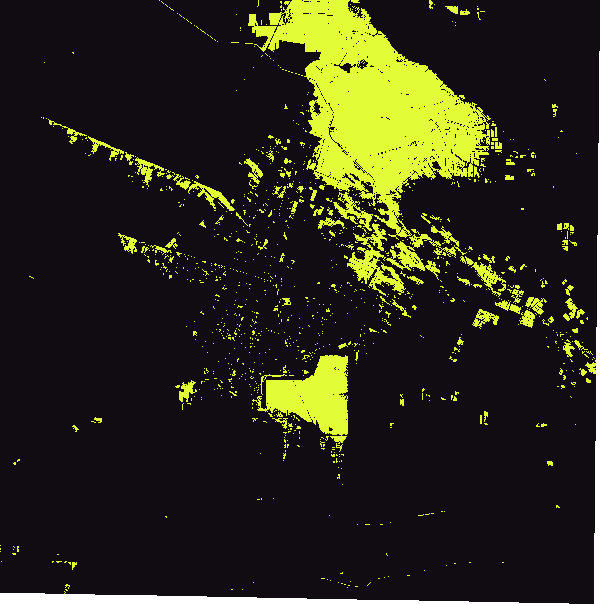

In [14]:
# 创建重映射对象，将1重映射为0
remap_value = RemapValue([[1, 0]]) # 用法为[[oldValue, newValue],...]

# Reclassify 
after_water_mask_reclass = Reclassify(in_raster=after_water_confidence_raster, 
                                      reclass_field="value", 
                                      remap=remap_value)
after_water_mask_reclass

### 处理洪水前的影像
整合之前的代码然后将after替换为before，就可以处理洪水前的影像了。

In [15]:
# 提取洪水前影像的相应的波段变量
before_Blue, before_Green, before_Red, before_Red_Edge_1, before_NIR, before_SWIR2 = create_sen2_band_variables(before_img_folder)

# 1.计算SWI
before_swi_calc = RasterCalculator([before_Red_Edge_1, before_SWIR2], 
                 ["x", "y"],
                 "(x - y) / (x + y)", "IntersectionOf")
arcpy.AddMessage("SWI Successfully Generated")

# 2.计算NDWI
before_ndwi_calc = RasterCalculator([before_Green, before_NIR], 
                 ["x", "y"],
                 "(x - y) / (x + y)")

# 分离 SWI
before_swi_thresh_calc = Threshold(before_swi_calc)

# 分离 NDWI 
before_ndwi_thresh_calc = Threshold(before_ndwi_calc)

# 栅格代数运算符
before_water_confidence_raster = before_swi_thresh_calc + before_ndwi_thresh_calc

# 创建重映射对象，将1重映射为0
remap_value = RemapValue([[1, 0]])
# Reclassify 
before_water_mask_reclass = Reclassify(in_raster=before_water_confidence_raster, 
                                      reclass_field="value", 
                                      remap=remap_value)



### 分析前后水域的变化
现在，您将确定后影像中的哪些区域是洪水，而不是预先存在的水体。这称为变更分析。为此，您需要计算两个水掩膜栅格之间的差异，从洪水后水掩膜中减去洪水前的水掩膜。


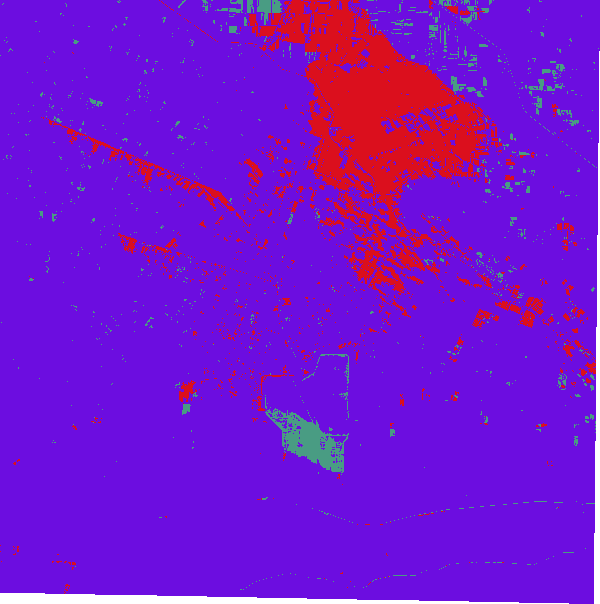

In [16]:
# 使用栅格运算符计算两个水掩膜栅格之间的差异
flooded_area_calc = after_water_mask_reclass - before_water_mask_reclass
flooded_area_calc

In [17]:
# 可选 保存
flooded_area_calc.save("flooded_area_calc")

结果栅格包含三种像素值：

| 像素值 | 描述            | 重要性             |
|-----|---------------|-----------------|
| 2   | 洪水之后的水像素      | **重要，为洪水影像的区域** |
| 0   | 没有水           | 不重要             |
| -2  | 洪水来之前有水，来之后没水 | 不重要             |

值为 2 的像素是新淹没的区域，我们把这一部分提取出来，就是我们最终的洪水区域，其余值不重要我们赋值为"NoData"，在软件中不会显示。

In [18]:
# 创建重映射对象，将2重映射为1，将0重映射为"NoData"
remap_value_final = RemapValue([[-2, "NoData"], [0, "NoData"]]) 

# Reclassify
flooded_area_final = Reclassify(in_raster=flooded_area_calc, 
                                reclass_field="value", 
                                remap=remap_value_final)

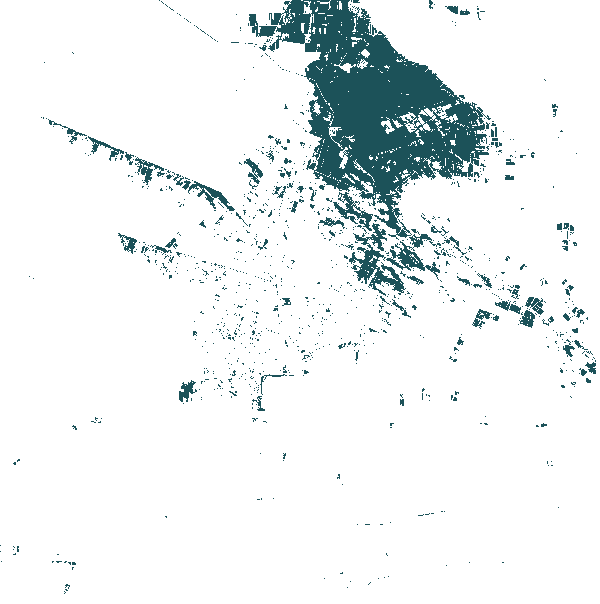

In [19]:
flooded_area_final

保存结果

In [20]:
# 保存到数据库 
flooded_area_final.save("Flooded_Area_Final_Raster")

In [10]:
# 保存为shapefile

# 处理栅格数据像素类型不是非整型的问题 
# 使用复制栅格 将像素类型设为整型（8位无符号）
arcpy.management.CopyRaster(
    in_raster="Flooded_Area_Final_Raster",
    out_rasterdataset="Flooded_Area_Final_CopyRaster",
    pixel_type="8_BIT_UNSIGNED",
    format="JP2",
)

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\Urban-Spatial-Data-Analysis-For-Beginners\\4-空间数据分析\\4.2-arcpy\\resource\\Classify_Imagery_with_Python\\Classify_Imagery_with_Python.gdb\\Flooded_Area_Final_CopyRaster'>

In [12]:
arcpy.conversion.RasterToPolygon(
    in_raster="Flooded_Area_Final_CopyRaster", # 要求是整型的像素类型 不然会报错ERROR 160333: 未找到表。
    out_polygon_features=os.path.join(final_output_folder, "Flooded_Area_Final.shp")
    simplify="SIMPLIFY",
    raster_field="Value",
    create_multipart_features="SINGLE_OUTER_PART",
    max_vertices_per_feature=None
)

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\Urban-Spatial-Data-Analysis-For-Beginners\\4-空间数据分析\\4.2-arcpy\\resource\\Classify_Imagery_with_Python\\Sentinel_2_Clipped\\Output\\Flooded_Area_Final.shp'>

In [ ]:
#

### 清理临时图层
由于您不需要临时图层，因此可以从地图中移除这些图层。执行此操作的一种方法是手动，右键单击单个图层并单击移除。您还可以使用 Python 代码删除所有临时层。

In [0]:
# Get the currently open ArcGIS Pro Project
aprx = arcpy.mp.ArcGISProject("current")
# Get the map
m = aprx.listMaps("地图")[0]
# Get a list of the layers on the map
thelyrs = m.listLayers()
# Check each layer to determine if it is a temporary, in memory layer, 
# and remove the layer if it is.
for lyr in thelyrs:
    # 可以加入判断条件
    m.removeLayer(lyr)

In [ ]:
## 制作脚本工具

在目录窗格中，右键单击文件夹，我们选择默认的工具箱 （.atbx）。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308250130820.png)

在目录窗格中，右键单击此工具箱，单击新建，然后单击脚本。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308250128614.png)

如图填好脚本相关参数：
常规选项卡：
![常规选项卡](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308250133511.png)

参数的顺序很重要。此表中的顺序必须与您使用 arcpy 在 Python 脚本中设置的顺序匹配。GetParameterAsText.在这种情况下，变量 before_img_folder 设置为第一个参数，设置为第二个参数， after_img_folder 并 final_output_folder 设置为第三个参数。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308250216546.png)

In [ ]:
import os
from glob import glob
import arcpy
from arcpy.sa import *

def create_sen2_band_variables(in_folder):
    """识别指定文件夹中相应哨兵2卫星光谱波段的文件，并将这些文件的路径存储在变量中。

    参数:
    in_folder: 指定文件夹

    返回值:
    Blue: 蓝光波段
    Green: 绿光波段
    Red: 红光波段
    Red_Edge_1: 红边波段1
    NIR: 近红外波段
    SWIR2: 短波红外波段
    """

    # 使用 arcpy.AddMessage 函数用于在程序中输出信息，方法同print
    arcpy.AddMessage("Creating variables for image bands...")

    # 使用 glob 模块获取输入文件夹中所有.jp2图像文件的列表
    band_list = glob(in_folder + "/*.jp2")

    # 使用列表推导查找与各种 Sentinel-2 波段对应的文件，并将其路径存储在具有各自名称（如 Blue 、、 Green Red 或 NIR ）的变量中。
    Blue = [x for x in band_list if x.endswith("B02.jp2")][0]
    Green = [x for x in band_list if x.endswith("B03.jp2")][0]
    Red = [x for x in band_list if x.endswith("B04.jp2")][0]
    Red_Edge_1 = [x for x in band_list if x.endswith("B05.jp2")][0]
    NIR = [x for x in band_list if x.endswith("B08.jp2")][0]
    SWIR2 = [x for x in band_list if x.endswith("B12.jp2")][0]

    # 返回包含图像文件路径的波段变量。
    return Blue, Green, Red, Red_Edge_1, NIR, SWIR2

# 提取洪水前影像的相应的波段变量
def caculate_water_mask_reclass(img_folder):
    """计算洪水后影像的水掩膜，并重分类为0和1。
    参数：
    img_folder: 洪水后影像所在的文件夹
    返回值：
    water_mask_reclass: 洪水后影像的水掩膜
    """
    # 当前处理的文件夹是：
    current_folder = os.path.basename(img_folder)
    arcpy.AddMessage("开始处理 {}...".format(current_folder))

    Blue, Green, Red, Red_Edge_1, NIR, SWIR2 = create_sen2_band_variables(img_folder)

    # 1.计算SWI
    swi_calc = RasterCalculator([Red_Edge_1, SWIR2],
                     ["x", "y"],
                     "(x - y) / (x + y)", "IntersectionOf")
    arcpy.AddMessage("SWI Successfully Generated")

    # 2.计算NDWI
    ndwi_calc = RasterCalculator([Green, NIR],
                     ["x", "y"],
                     "(x - y) / (x + y)")
    arcpy.AddMessage("NDWI Successfully Generated")

    # 分离 SWI
    swi_thresh_calc = Threshold(swi_calc)
    arcpy.AddMessage("SWI Threshold Successfully Generated")

    # 分离 NDWI
    ndwi_thresh_calc = Threshold(ndwi_calc)
    arcpy.AddMessage("NDWI Threshold Successfully Generated")

    # 栅格代数运算符
    water_confidence_raster = swi_thresh_calc + ndwi_thresh_calc
    arcpy.AddMessage("Water Confidence Raster Successfully Generated")

    # 创建重映射对象，将1重映射为0
    remap_value = RemapValue([[1, 0]])
    # Reclassify
    water_mask_reclass = Reclassify(in_raster=water_confidence_raster,
                                          reclass_field="value",
                                          remap=remap_value)
    arcpy.AddMessage("Water Mask Reclass Successfully Generated")
    return water_mask_reclass

if __name__ == '__main__':
    # 洪水前影像所在的文件夹
    # before_img_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\Before")
    before_img_folder = arcpy.GetParameterAsText(0)
    # 洪水后影像所在的文件夹
    # after_img_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\After")
    after_img_folder = arcpy.GetParameterAsText(1)

    # 最后成功输出的文件夹
    # final_output_folder = os.path.join(home_dir, "Sentinel_2_Clipped\\Output")
    final_output_folder = arcpy.GetParameterAsText(2)

    flooded_area_calc = caculate_water_mask_reclass(after_img_folder) - caculate_water_mask_reclass(before_img_folder)

    # 创建重映射对象，将2重映射为1，将0重映射为"NoData"
    remap_value_final = RemapValue([[-2, "NoData"], [0, "NoData"]])

    # Reclassify
    flooded_area_final = Reclassify(in_raster=flooded_area_calc,
                                    reclass_field="value",
                                    remap=remap_value_final)
    arcpy.AddMessage("Flooded Area Final Raster Successfully Generated")

    # 使用复制栅格 将像素类型设为整型（8位无符号）
    arcpy.management.CopyRaster(
        in_raster=flooded_area_final,
        out_rasterdataset="Flooded_Area_Final_CopyRaster",
        pixel_type="8_BIT_UNSIGNED",
        format="JP2",
    )
    arcpy.AddMessage("Flooded Area Final Copy Raster Successfully Generated")


    # 保存为shapefile
    arcpy.conversion.RasterToPolygon(
        in_raster="Flooded_Area_Final_CopyRaster", # 要求是整型的像素类型 不然会报错ERROR 160333: 未找到表。
        out_polygon_features=os.path.join(final_output_folder, "Flooded_Area_Final.shp"),
        simplify="SIMPLIFY",
        raster_field="Value",
        create_multipart_features="SINGLE_OUTER_PART",
        max_vertices_per_feature=None)
    arcpy.AddMessage("Flooded Area Final Polygon Successfully Generated")

    # 删除复制的栅格数据集
    arcpy.management.Delete(
        in_data="Flooded_Area_Final_CopyRaster",
        data_type="")

工具箱脚本可改进的地方：
1. 可以加入判断条件，如果输入的文件夹中没有影像，就不进行计算。
2. 给工具箱增加元数据说明，方便使用者使用。

### 使用条款
This tutorial was originally developed by Esri's Learn Team. 
You can find the official maintained version at this location : [Classify Imagery to detect flooding with Python](https://learngis.maps.arcgis.com/home/item.html?id=24e13f2f4fe8453b9d1107e1f5b1d3cf).
You can find other tutorials in the tutorial gallery [https://learn.arcgis.com/en/gallery/].
This notebook has been edited by me. If you wish to reproduce it, please provide attribution according to the [Creative Commons 许可 (CC BY-SA-NC)](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).

本教程最初由Esri的学习团队开发。
你可以在这个位置找到官方维护的版本：[使用Python进行影像分类以检测洪水](https://learngis.maps.arcgis.com/home/item.html?id=24e13f2f4fe8453b9d1107e1f5b1d3cf)。
你可以在教程库中找到其他教程：[https://learn.arcgis.com/en/gallery/]。
本notebook经过本人的编辑，转载请依据 [Creative Commons 许可 (CC BY-SA-NC)](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode) 协议注明出处。 
![](https://learn.arcgis.com/assets/images/by-nc-sa.png)